In [38]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# LightGBM
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("LightGBM not available, installing...")
    !pip install lightgbm -q
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


---
## Load and Prepare Data

In [39]:
# Load the model-ready dataset
df = pd.read_csv('../data/model_ready_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"\nCrops: {df['item'].unique().tolist()}")
print(f"Markets: {df['market'].nunique()} unique markets")

Dataset Shape: 109,200 rows × 23 columns
Date Range: 2020-01-08 to 2024-12-31

Crops: ['Beetroot', 'Raddish', 'Red Onion', 'Rice']
Markets: 15 unique markets


In [40]:
# Define forecast horizons (in days)
HORIZONS = {
    '1_week': 7,
    '2_weeks': 14,
    '4_weeks': 28,
    '8_weeks': 56,
    '12_weeks': 84
}

print("Forecast Horizons:")
for name, days in HORIZONS.items():
    print(f"  • {name}: {days} days ahead")

Forecast Horizons:
  • 1_week: 7 days ahead
  • 2_weeks: 14 days ahead
  • 4_weeks: 28 days ahead
  • 8_weeks: 56 days ahead
  • 12_weeks: 84 days ahead


In [41]:
# Aggregate data by Date and Crop (average across all markets)


df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.dayofweek
df['quarter'] = df['Date'].dt.quarter

agg_df = df.groupby(['Date', 'item']).agg({
    'price': 'mean',
    'volume_MT': 'mean',
    'temperature_avg_C': 'mean',
    'rainfall_mm': 'mean',
    'humidity_percent': 'mean',
    'month': 'first',
    'day_of_week': 'first',
    'quarter': 'first',
    'is_public_holiday': 'max',
    'is_day_before_holiday': 'max',
    'near_major_holiday': 'max',
    'demand_multiplier': 'mean',
    'harvest_period_rice': 'max',
    'vegetable_peak_season': 'max'
}).reset_index()

agg_df = agg_df.sort_values(['item', 'Date']).reset_index(drop=True)

print(f"Aggregated data shape: {agg_df.shape}")
print(f"\nRecords per crop:")
print(agg_df.groupby('item').size())

Aggregated data shape: (7280, 16)

Records per crop:
item
Beetroot     1820
Raddish      1820
Red Onion    1820
Rice         1820
dtype: int64


---
## Create Multi-Horizon Target Variables

In [42]:
def create_multi_horizon_targets(df, target_col='price', horizons=HORIZONS):
    """
    Create future target columns for each horizon.
    For each row, we want to predict the price at t+h days.
    """
    df = df.copy()
    
    for horizon_name, days in horizons.items():
        # Shift price backwards (so current row has future price as target)
        df[f'target_{horizon_name}'] = df.groupby('item')[target_col].shift(-days)
    
    return df

# Create targets
agg_df = create_multi_horizon_targets(agg_df)

# Check target columns
target_cols = [col for col in agg_df.columns if col.startswith('target_')]
print("Target columns created:")
for col in target_cols:
    non_null = agg_df[col].notna().sum()
    print(f"  • {col}: {non_null:,} valid samples")

Target columns created:
  • target_1_week: 7,252 valid samples
  • target_2_weeks: 7,224 valid samples
  • target_4_weeks: 7,168 valid samples
  • target_8_weeks: 7,056 valid samples
  • target_12_weeks: 6,944 valid samples


In [43]:
# Add lag features for better prediction
def add_lag_features(df, lags=[1, 7, 14, 28]):
    """
    Add lagged price and volume features.
    """
    df = df.copy()
    
    for lag in lags:
        df[f'price_lag_{lag}'] = df.groupby('item')['price'].shift(lag)
        df[f'volume_lag_{lag}'] = df.groupby('item')['volume_MT'].shift(lag)
    
    # Rolling statistics
    df['price_rolling_7_mean'] = df.groupby('item')['price'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    df['price_rolling_7_std'] = df.groupby('item')['price'].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )
    df['price_rolling_28_mean'] = df.groupby('item')['price'].transform(
        lambda x: x.rolling(window=28, min_periods=1).mean()
    )
    
    # Price momentum (change from lag)
    df['price_momentum_7'] = df['price'] - df['price_lag_7']
    df['price_momentum_28'] = df['price'] - df['price_lag_28']
    
    return df

agg_df = add_lag_features(agg_df)
print(f"Features added. Total columns: {len(agg_df.columns)}")

Features added. Total columns: 34


---
## Baseline Model: Seasonal Naïve

In [44]:
def seasonal_naive_forecast(df, horizon_days, seasonal_period=7):
    
    df = df.copy()
   
    predictions = df.groupby('item')['price'].shift(seasonal_period)
    
    return predictions

# Calculate seasonal naive baseline for each horizon
baseline_results = {}

print("Seasonal Naïve Baseline Results:")

for horizon_name, days in HORIZONS.items():
    target_col = f'target_{horizon_name}'
    
 
    y_true = agg_df[target_col].dropna()
    y_pred_naive = agg_df['price'].loc[y_true.index]  # Use current price as naive baseline
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred_naive)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_naive))
    mape = np.mean(np.abs((y_true - y_pred_naive) / y_true)) * 100
    
    baseline_results[horizon_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }
    
    print(f"\n{horizon_name} ({days} days):")
    print(f"  MAE:  {mae:.2f} LKR")
    print(f"  RMSE: {rmse:.2f} LKR")
    print(f"  MAPE: {mape:.2f}%")

Seasonal Naïve Baseline Results:

1_week (7 days):
  MAE:  11.77 LKR
  RMSE: 17.16 LKR
  MAPE: 4.71%

2_weeks (14 days):
  MAE:  12.68 LKR
  RMSE: 18.39 LKR
  MAPE: 5.07%

4_weeks (28 days):
  MAE:  14.74 LKR
  RMSE: 21.03 LKR
  MAPE: 5.88%

8_weeks (56 days):
  MAE:  19.54 LKR
  RMSE: 27.41 LKR
  MAPE: 7.78%

12_weeks (84 days):
  MAE:  22.44 LKR
  RMSE: 31.54 LKR
  MAPE: 8.85%


---
## LightGBM Multi-Horizon Models (Direct Approach)

In [45]:
# Prepare feature columns
feature_cols = [
    # Current values
    'price', 'volume_MT',
    
    # Weather
    'temperature_avg_C', 'rainfall_mm', 'humidity_percent',
    
    # Time features
    'month', 'day_of_week', 'quarter',
    
    # Seasonal/Holiday features
    'is_public_holiday', 'is_day_before_holiday', 'near_major_holiday',
    'demand_multiplier', 'harvest_period_rice', 'vegetable_peak_season',
    
    # Lag features
    'price_lag_1', 'price_lag_7', 'price_lag_14', 'price_lag_28',
    'volume_lag_1', 'volume_lag_7', 'volume_lag_14', 'volume_lag_28',
    
    # Rolling statistics
    'price_rolling_7_mean', 'price_rolling_7_std', 'price_rolling_28_mean',
    
    # Momentum
    'price_momentum_7', 'price_momentum_28'
]

# Add item encoding
le_item = LabelEncoder()
agg_df['item_encoded'] = le_item.fit_transform(agg_df['item'])
feature_cols.append('item_encoded')

# Check available features
available_features = [col for col in feature_cols if col in agg_df.columns]
print(f"Features available: {len(available_features)}/{len(feature_cols)}")

Features available: 28/28


In [46]:
# Train LightGBM model for each horizon (Direct Multi-Horizon approach)
lgb_models = {}
lgb_results = {}

# Prepare clean dataset (drop rows with NaN in features)
df_clean = agg_df.dropna(subset=available_features).copy()
print(f"Clean dataset: {len(df_clean):,} rows")

# Time-based split (80% train, 20% test)
split_idx = int(len(df_clean) * 0.8)


for horizon_name, days in HORIZONS.items():
    target_col = f'target_{horizon_name}'
    
    # Drop rows where target is NaN
    df_horizon = df_clean.dropna(subset=[target_col]).copy()
    
    if len(df_horizon) < 100:
        print(f"\n{horizon_name}: Insufficient data, skipping...")
        continue
    
    # Prepare X and y
    X = df_horizon[available_features]
    y = df_horizon[target_col]
    
    # Time-based split
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'seed': 42
    }
    
    # Train model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    lgb_models[horizon_name] = model
    lgb_results[horizon_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'y_test': y_test.values,
        'y_pred': y_pred,
        'n_samples': len(y_test)
    }
    
    print(f"\n{horizon_name} ({days} days ahead):")
    print(f"  Samples: {len(y_train):,} train, {len(y_test):,} test")
    print(f"  MAE:  {mae:.2f} LKR")
    print(f"  RMSE: {rmse:.2f} LKR")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

Clean dataset: 7,168 rows
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's rmse: 10.031

1_week (7 days ahead):
  Samples: 5,712 train, 1,428 test
  MAE:  7.98 LKR
  RMSE: 10.03 LKR
  R²:   0.8509
  MAPE: 3.68%
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[165]	valid_0's rmse: 10.031

1_week (7 days ahead):
  Samples: 5,712 train, 1,428 test
  MAE:  7.98 LKR
  RMSE: 10.03 LKR
  R²:   0.8509
  MAPE: 3.68%
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's rmse: 10.4767

2_weeks (14 days ahead):
  Samples: 5,689 train, 1,423 test
  MAE:  8.37 LKR
  RMSE: 10.48 LKR
  R²:   0.8365
  MAPE: 3.85%
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[271]	valid_0's rmse: 10.4767

2_weeks (14 days ahead):
  Samples: 5,6

---
## LSTM Multi-Output Model (Joint Prediction)

In [47]:
def create_sequences_multi_output(data, targets, seq_length=14):

    X_seq, y_seq = [], []
    
    for i in range(len(data) - seq_length):
        # Check if all targets are valid (not NaN)
        if not np.isnan(targets[i + seq_length]).any():
            X_seq.append(data[i:i + seq_length])
            y_seq.append(targets[i + seq_length])
    
    return np.array(X_seq), np.array(y_seq)

# LSTM sequence length
SEQ_LENGTH = 14  # 2 weeks of history
print(f"Sequence length: {SEQ_LENGTH} days")

Sequence length: 14 days


In [48]:
# Prepare data for LSTM (per crop)
lstm_features = [
    'price', 'volume_MT', 'temperature_avg_C', 'rainfall_mm', 
    'humidity_percent', 'month', 'day_of_week',
    'is_public_holiday', 'demand_multiplier'
]

target_cols = [f'target_{h}' for h in HORIZONS.keys()]

# Train LSTM for each crop
lstm_models_multi = {}
lstm_results_multi = {}
lstm_scalers_X = {}
lstm_scalers_y = {}

crops = agg_df['item'].unique()

print("LSTM MULTI-HORIZON FORECASTING (Per Crop)")

for crop in crops:
    print(f"\n{'='*60}")
    print(f"Training LSTM for: {crop}")
    print('='*60)
    
    # Get crop data
    crop_df = agg_df[agg_df['item'] == crop].copy()
    crop_df = crop_df.sort_values('Date').reset_index(drop=True)
    
    # Drop rows with NaN in features or any target
    crop_df = crop_df.dropna(subset=lstm_features + target_cols)
    
    if len(crop_df) < 100:
        print(f"  Insufficient data ({len(crop_df)} rows), skipping...")
        continue
    
    print(f"  Data points: {len(crop_df)}")
    
    # Prepare features and targets
    X_crop = crop_df[lstm_features].values
    y_crop = crop_df[target_cols].values  # Multiple targets
    
    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_crop)
    lstm_scalers_X[crop] = scaler_X
    
    # Scale targets (each horizon separately)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y_crop)
    lstm_scalers_y[crop] = scaler_y
    
    # Create sequences
    X_seq, y_seq = create_sequences_multi_output(X_scaled, y_scaled, SEQ_LENGTH)
    
    if len(X_seq) < 50:
        print(f"  Insufficient sequences ({len(X_seq)}), skipping...")
        continue
    
    print(f"  Total sequences: {len(X_seq)}")
    
    # Time-based split
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    
    print(f"  Train: {len(X_train)}, Test: {len(X_test)}")
    
    # Build Multi-Output LSTM model
    n_horizons = len(HORIZONS)
    
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), 
                      input_shape=(SEQ_LENGTH, len(lstm_features))),
        Dropout(0.3),
        Bidirectional(LSTM(32, return_sequences=False)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(n_horizons)  # Output: predictions for all horizons
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)
    
    # Train
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    print(f"  Epochs trained: {len(history.history['loss'])}")
    
    # Predict
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # Inverse transform
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled)
    y_test_original = scaler_y.inverse_transform(y_test)
    
    # Store model
    lstm_models_multi[crop] = model
    
    # Calculate metrics for each horizon
    crop_results = {}
    print(f"\n  Results by horizon:")
    
    for i, horizon_name in enumerate(HORIZONS.keys()):
        y_true_h = y_test_original[:, i]
        y_pred_h = y_pred_original[:, i]
        
        mae = mean_absolute_error(y_true_h, y_pred_h)
        rmse = np.sqrt(mean_squared_error(y_true_h, y_pred_h))
        r2 = r2_score(y_true_h, y_pred_h)
        mape = np.mean(np.abs((y_true_h - y_pred_h) / y_true_h)) * 100
        
        crop_results[horizon_name] = {
            'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape,
            'y_test': y_true_h, 'y_pred': y_pred_h
        }
        
        print(f"    {horizon_name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")
    
    lstm_results_multi[crop] = crop_results

LSTM MULTI-HORIZON FORECASTING (Per Crop)

Training LSTM for: Beetroot
  Data points: 1736
  Total sequences: 1722
  Train: 1377, Test: 345
  Epochs trained: 43

  Results by horizon:
    1_week: MAE=13.70, RMSE=17.15, R²=0.1944
    2_weeks: MAE=12.63, RMSE=15.94, R²=0.2977
    4_weeks: MAE=12.52, RMSE=15.60, R²=0.3342
    8_weeks: MAE=13.64, RMSE=16.74, R²=0.2344
    12_weeks: MAE=13.72, RMSE=16.80, R²=0.2434

Training LSTM for: Raddish
  Data points: 1736
  Total sequences: 1722
  Train: 1377, Test: 345
  Epochs trained: 38

  Results by horizon:
    1_week: MAE=5.33, RMSE=6.79, R²=0.3709
    2_weeks: MAE=5.55, RMSE=6.93, R²=0.3571
    4_weeks: MAE=5.53, RMSE=6.84, R²=0.3799
    8_weeks: MAE=5.70, RMSE=7.04, R²=0.3410
    12_weeks: MAE=6.16, RMSE=7.63, R²=0.2831

Training LSTM for: Red Onion
  Data points: 1736
  Total sequences: 1722
  Train: 1377, Test: 345
  Epochs trained: 30

  Results by horizon:
    1_week: MAE=24.57, RMSE=31.46, R²=0.5017
    2_weeks: MAE=26.53, RMSE=33.43, R

---
## Results Comparison

In [49]:

comparison_data = []

for horizon_name, days in HORIZONS.items():
    row = {'Horizon': f"{horizon_name} ({days}d)"}
    
    # Baseline
    if horizon_name in baseline_results:
        row['Baseline MAE'] = baseline_results[horizon_name]['MAE']
        row['Baseline RMSE'] = baseline_results[horizon_name]['RMSE']
    
    # LightGBM
    if horizon_name in lgb_results:
        row['LightGBM MAE'] = lgb_results[horizon_name]['MAE']
        row['LightGBM RMSE'] = lgb_results[horizon_name]['RMSE']
        row['LightGBM R²'] = lgb_results[horizon_name]['R2']
    
    # LSTM (average across crops)
    lstm_maes = []
    lstm_rmses = []
    lstm_r2s = []
    for crop in lstm_results_multi:
        if horizon_name in lstm_results_multi[crop]:
            lstm_maes.append(lstm_results_multi[crop][horizon_name]['MAE'])
            lstm_rmses.append(lstm_results_multi[crop][horizon_name]['RMSE'])
            lstm_r2s.append(lstm_results_multi[crop][horizon_name]['R2'])
    
    if lstm_maes:
        row['LSTM MAE'] = np.mean(lstm_maes)
        row['LSTM RMSE'] = np.mean(lstm_rmses)
        row['LSTM R²'] = np.mean(lstm_r2s)
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

       Horizon  Baseline MAE  Baseline RMSE  LightGBM MAE  LightGBM RMSE  LightGBM R²  LSTM MAE  LSTM RMSE  LSTM R²
   1_week (7d)     11.772786      17.156609      7.975499      10.031003     0.850938 14.071911  18.004484 0.312011
 2_weeks (14d)     12.681711      18.393235      8.367305      10.476653     0.836451 14.049297  17.873250 0.359560
 4_weeks (28d)     14.740381      21.030769      8.144688      10.202597     0.843456 14.856387  18.685756 0.344961
 8_weeks (56d)     19.539001      27.410658      9.630285      12.248128     0.766964 15.890952  19.631607 0.270991
12_weeks (84d)     22.440129      31.535744     10.957869      13.622872     0.698492 17.325874  21.049253 0.222691


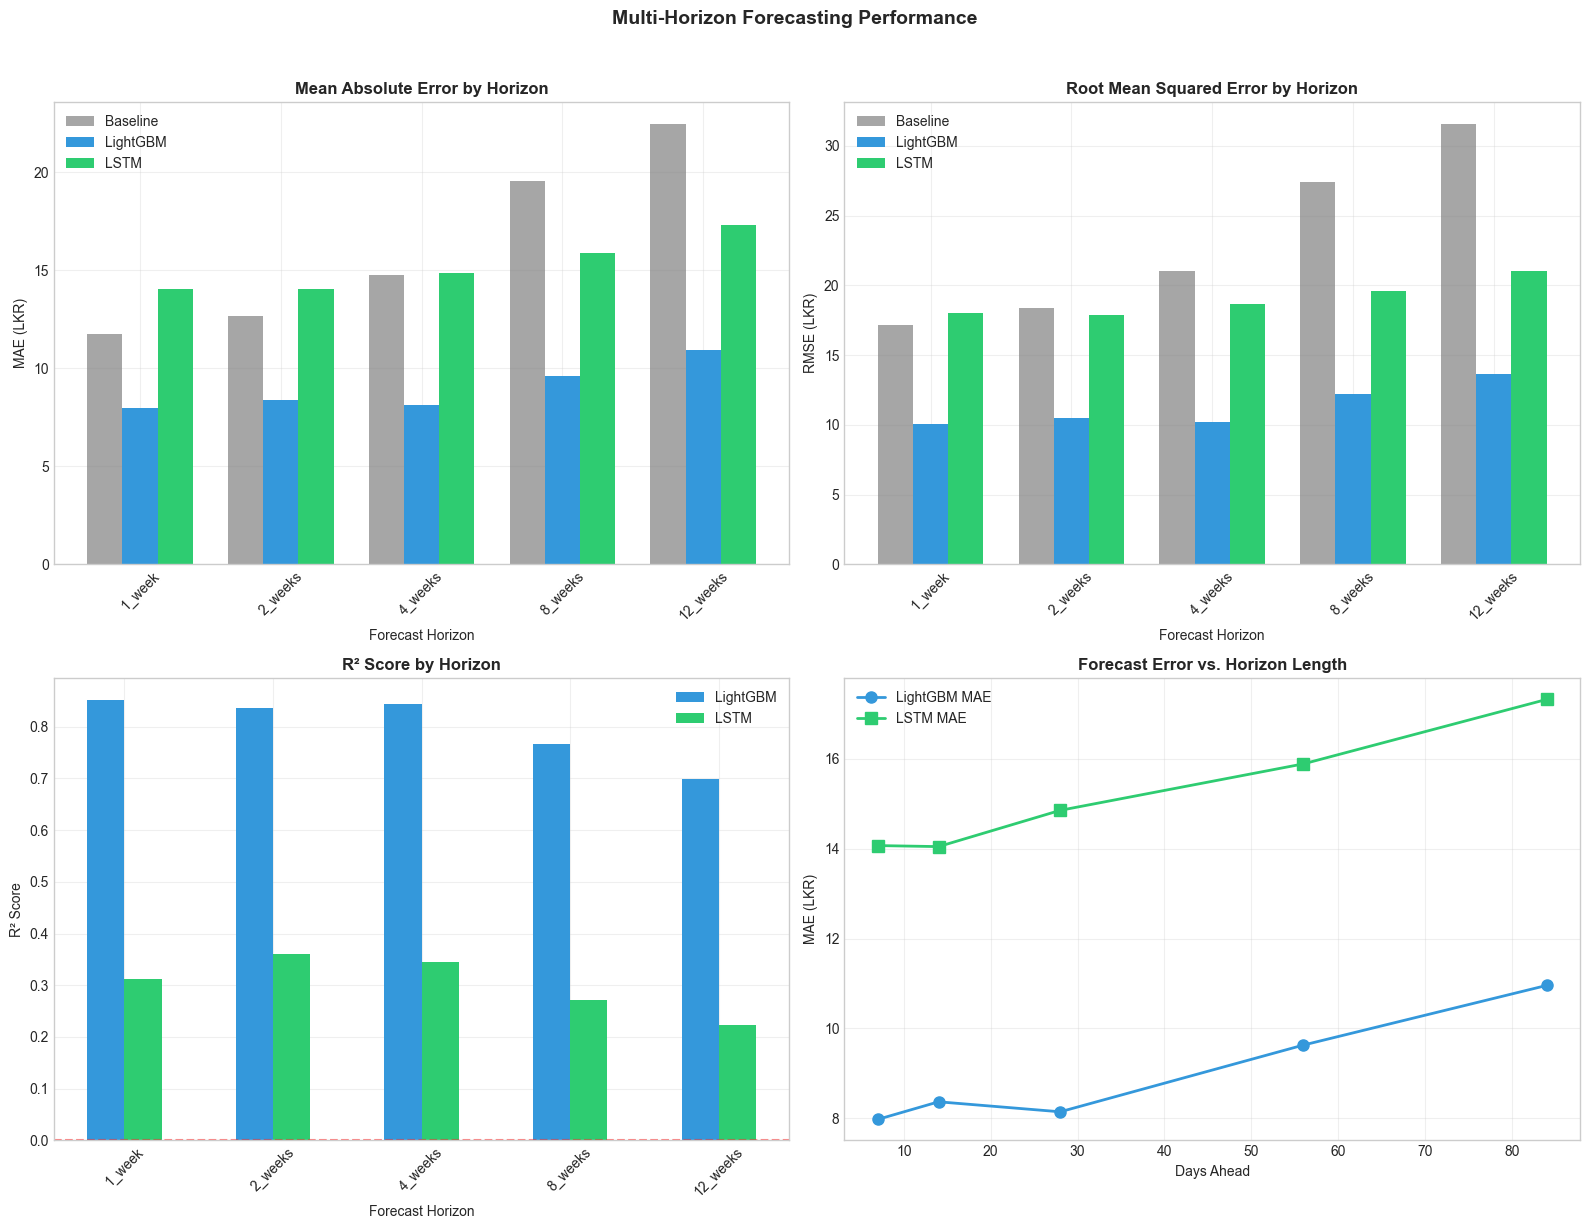

In [50]:
# Visualize performance across horizons
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

horizons_labels = [f"{h}" for h in HORIZONS.keys()]
x = np.arange(len(horizons_labels))
width = 0.25

# 1. MAE Comparison
ax1 = axes[0, 0]
baseline_mae = [baseline_results.get(h, {}).get('MAE', 0) for h in HORIZONS.keys()]
lgb_mae = [lgb_results.get(h, {}).get('MAE', 0) for h in HORIZONS.keys()]
lstm_mae = []
for h in HORIZONS.keys():
    vals = [lstm_results_multi[c][h]['MAE'] for c in lstm_results_multi if h in lstm_results_multi[c]]
    lstm_mae.append(np.mean(vals) if vals else 0)

ax1.bar(x - width, baseline_mae, width, label='Baseline', color='gray', alpha=0.7)
ax1.bar(x, lgb_mae, width, label='LightGBM', color='#3498db')
ax1.bar(x + width, lstm_mae, width, label='LSTM', color='#2ecc71')
ax1.set_xlabel('Forecast Horizon')
ax1.set_ylabel('MAE (LKR)')
ax1.set_title('Mean Absolute Error by Horizon', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(horizons_labels, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. RMSE Comparison
ax2 = axes[0, 1]
baseline_rmse = [baseline_results.get(h, {}).get('RMSE', 0) for h in HORIZONS.keys()]
lgb_rmse = [lgb_results.get(h, {}).get('RMSE', 0) for h in HORIZONS.keys()]
lstm_rmse = []
for h in HORIZONS.keys():
    vals = [lstm_results_multi[c][h]['RMSE'] for c in lstm_results_multi if h in lstm_results_multi[c]]
    lstm_rmse.append(np.mean(vals) if vals else 0)

ax2.bar(x - width, baseline_rmse, width, label='Baseline', color='gray', alpha=0.7)
ax2.bar(x, lgb_rmse, width, label='LightGBM', color='#3498db')
ax2.bar(x + width, lstm_rmse, width, label='LSTM', color='#2ecc71')
ax2.set_xlabel('Forecast Horizon')
ax2.set_ylabel('RMSE (LKR)')
ax2.set_title('Root Mean Squared Error by Horizon', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(horizons_labels, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. R² Score by Horizon
ax3 = axes[1, 0]
lgb_r2 = [lgb_results.get(h, {}).get('R2', 0) for h in HORIZONS.keys()]
lstm_r2 = []
for h in HORIZONS.keys():
    vals = [lstm_results_multi[c][h]['R2'] for c in lstm_results_multi if h in lstm_results_multi[c]]
    lstm_r2.append(np.mean(vals) if vals else 0)

ax3.bar(x - width/2, lgb_r2, width, label='LightGBM', color='#3498db')
ax3.bar(x + width/2, lstm_r2, width, label='LSTM', color='#2ecc71')
ax3.set_xlabel('Forecast Horizon')
ax3.set_ylabel('R² Score')
ax3.set_title('R² Score by Horizon', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(horizons_labels, rotation=45)
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Performance Degradation with Horizon
ax4 = axes[1, 1]
days_ahead = list(HORIZONS.values())
ax4.plot(days_ahead, lgb_mae, 'o-', label='LightGBM MAE', color='#3498db', linewidth=2, markersize=8)
ax4.plot(days_ahead, lstm_mae, 's-', label='LSTM MAE', color='#2ecc71', linewidth=2, markersize=8)
ax4.set_xlabel('Days Ahead')
ax4.set_ylabel('MAE (LKR)')
ax4.set_title('Forecast Error vs. Horizon Length', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Multi-Horizon Forecasting Performance', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Prediction Visualization by Crop

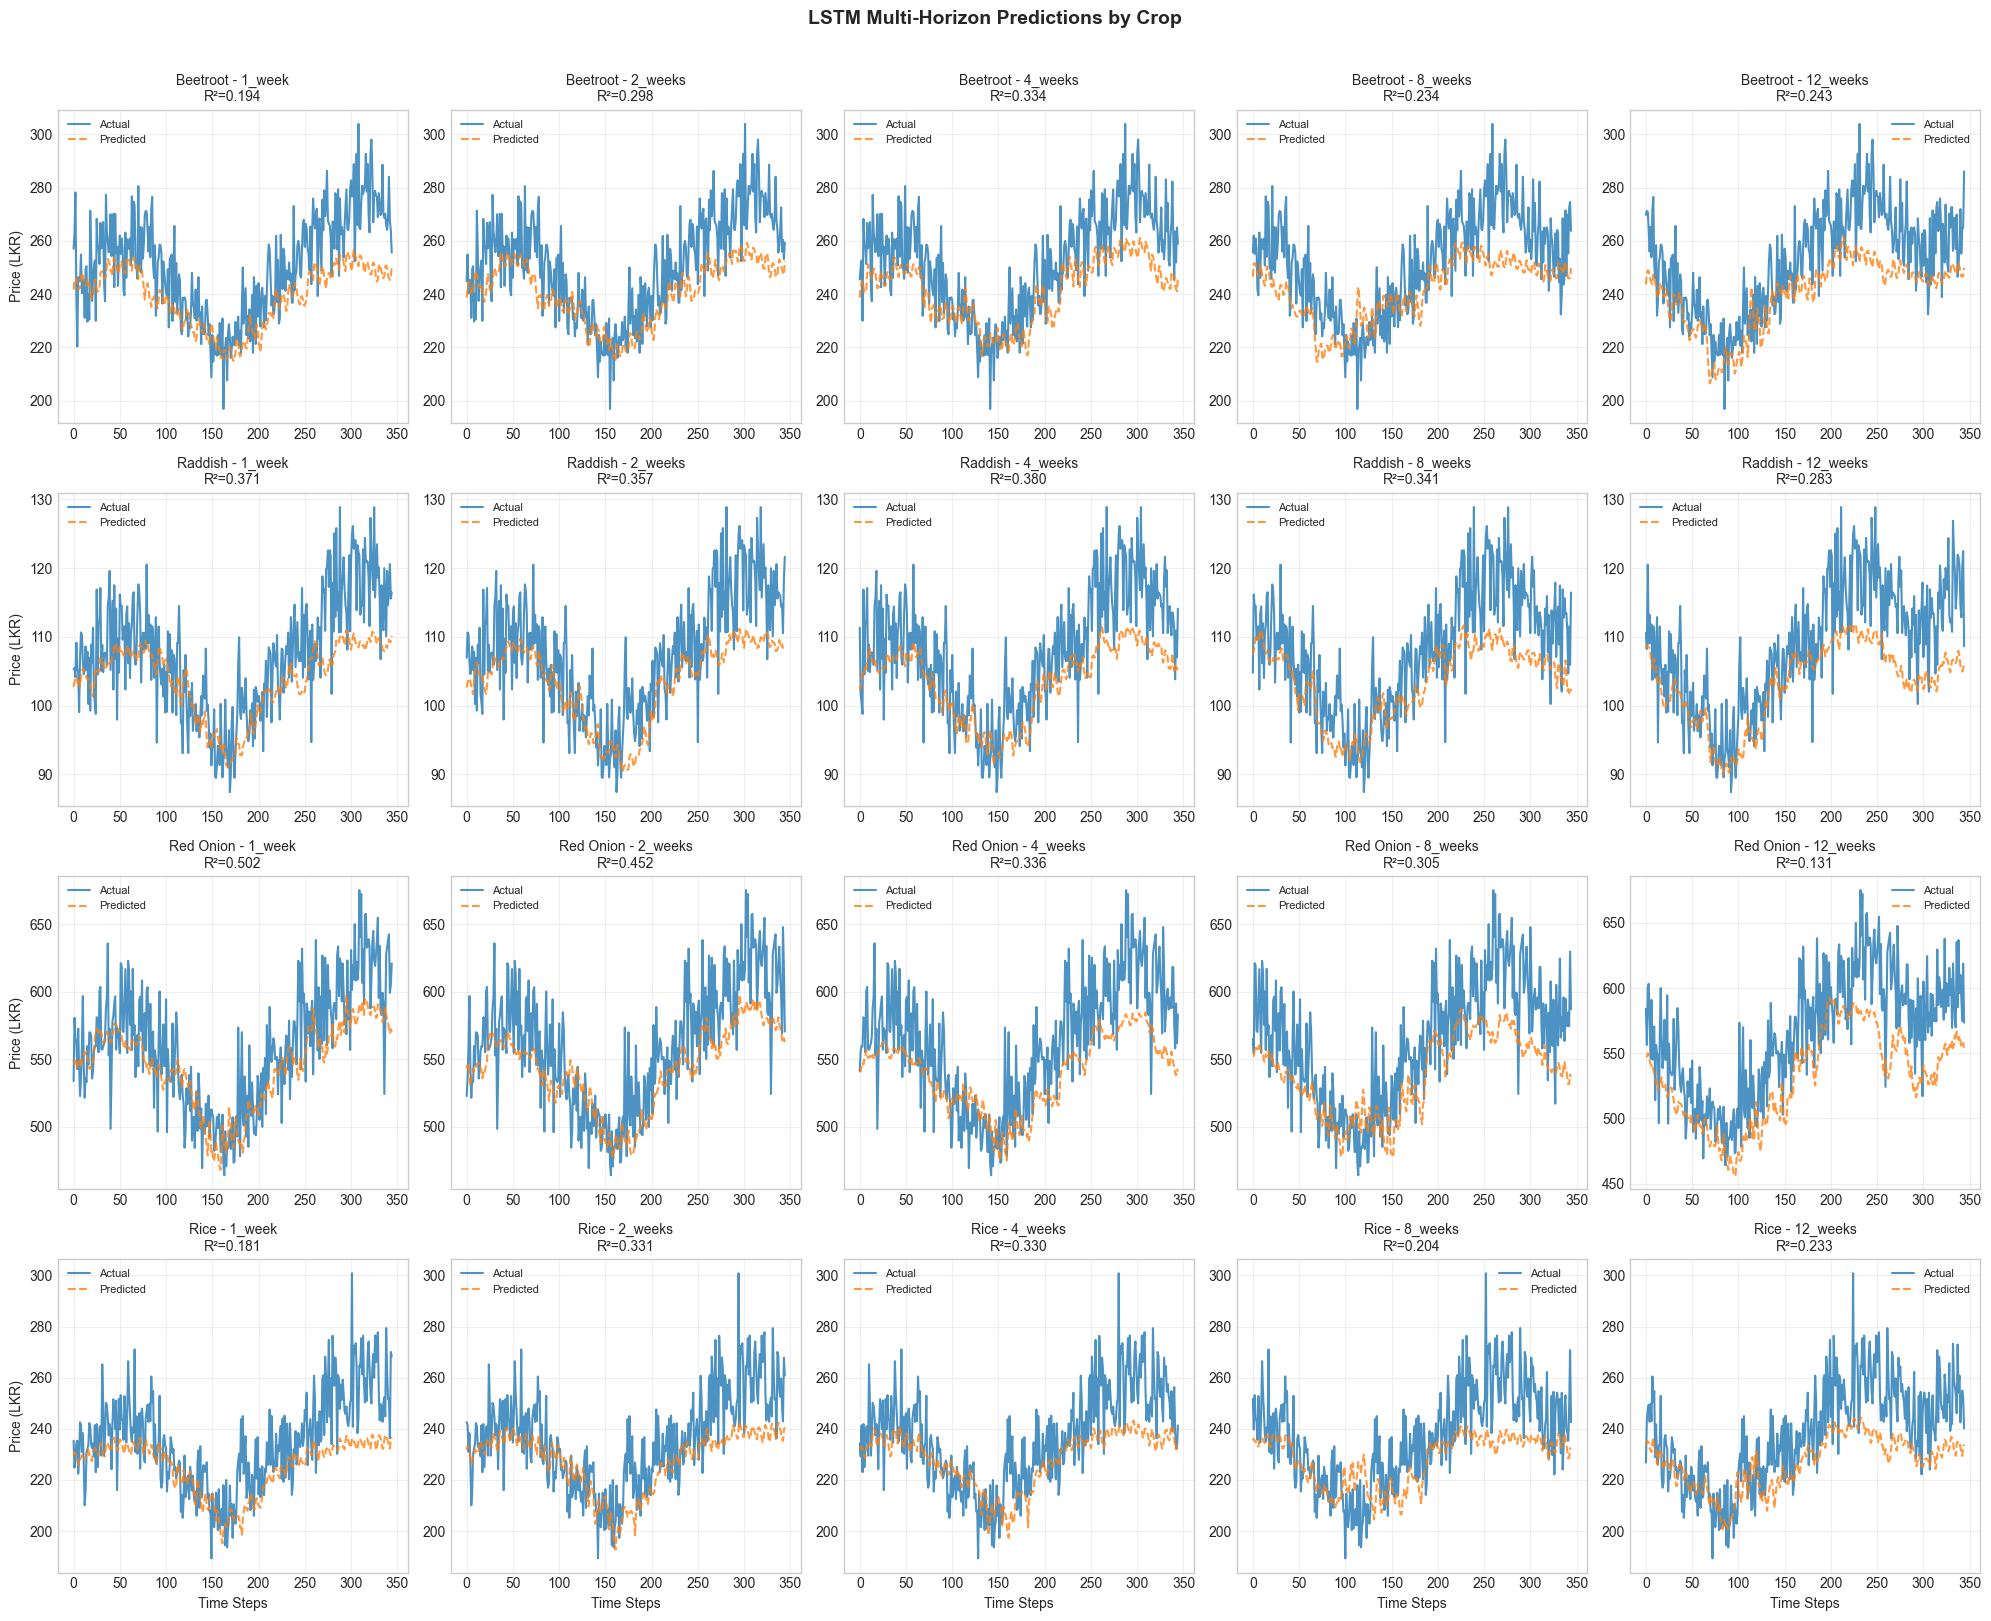

In [51]:
# Visualize predictions for each crop at different horizons
fig, axes = plt.subplots(len(lstm_results_multi), len(HORIZONS), figsize=(20, 4*len(lstm_results_multi)))

if len(lstm_results_multi) == 1:
    axes = axes.reshape(1, -1)

for i, crop in enumerate(lstm_results_multi.keys()):
    for j, horizon_name in enumerate(HORIZONS.keys()):
        ax = axes[i, j]
        
        if horizon_name in lstm_results_multi[crop]:
            y_test = lstm_results_multi[crop][horizon_name]['y_test']
            y_pred = lstm_results_multi[crop][horizon_name]['y_pred']
            r2 = lstm_results_multi[crop][horizon_name]['R2']
            
            ax.plot(y_test, label='Actual', alpha=0.8, linewidth=1.5)
            ax.plot(y_pred, label='Predicted', alpha=0.8, linewidth=1.5, linestyle='--')
            ax.set_title(f'{crop} - {horizon_name}\nR²={r2:.3f}', fontsize=10)
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        
        if j == 0:
            ax.set_ylabel('Price (LKR)')
        if i == len(lstm_results_multi) - 1:
            ax.set_xlabel('Time Steps')

plt.suptitle('LSTM Multi-Horizon Predictions by Crop', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## 8. Save Models and Results

In [52]:
import joblib
import os

# Create directory for multi-horizon models
save_dir = '../models/saved_models/multi_horizon'
os.makedirs(save_dir, exist_ok=True)

# Save LightGBM models
for horizon_name, model in lgb_models.items():
    model_path = f'{save_dir}/lgb_{horizon_name}_model.txt'
    model.save_model(model_path)

# Save LSTM models
for crop, model in lstm_models_multi.items():
    crop_name = crop.lower().replace(' ', '_')
    model_path = f'{save_dir}/lstm_multi_{crop_name}.keras'
    model.save(model_path)

# Save scalers
joblib.dump(lstm_scalers_X, f'{save_dir}/lstm_scalers_X.joblib')
joblib.dump(lstm_scalers_y, f'{save_dir}/lstm_scalers_y.joblib')


# Save configuration
config = {
    'horizons': HORIZONS,
    'seq_length': SEQ_LENGTH,
    'lstm_features': lstm_features,
    'lgb_features': available_features,
    'crops': list(lstm_models_multi.keys())
}
joblib.dump(config, f'{save_dir}/config.joblib')

# Save results summary
results_summary = {
    'baseline': baseline_results,
    'lightgbm': {k: {kk: vv for kk, vv in v.items() if kk not in ['y_test', 'y_pred']} 
                for k, v in lgb_results.items()},
    'lstm': {crop: {h: {kk: vv for kk, vv in metrics.items() if kk not in ['y_test', 'y_pred']}
                    for h, metrics in horizons.items()}
             for crop, horizons in lstm_results_multi.items()}
}
joblib.dump(results_summary, f'{save_dir}/results_summary.joblib')

['../models/saved_models/multi_horizon/results_summary.joblib']